In [1]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist


In [2]:
with open('High/High Grass.obj') as f:
    data = f.read().strip().split('\n')


vertices = np.array([[float(j) for j in i[2:].split(' ')] for i in data if i.startswith('v ')])
faces = [i.strip() for i in data if i.startswith('f ')]
texture_vertices = np.array([[float(j) for j in i[3:].split(' ')] for i in data if i.startswith('vt ')])


# Separate grasses

In [3]:
# fine primitive clusters
v_clusters = []
f_clusters = []
for face in faces:
    face_vs = [int(f.split('/')[0]) for f in face.strip().split()[1:]]
    v_cluster_index = None
    for candind_index, candid_cluster in enumerate(v_clusters):
        if any([v in candid_cluster for v in face_vs]):
            v_cluster_index = candind_index
            break
    if v_cluster_index is not None:
        v_clusters[v_cluster_index].update(set(face_vs))
        f_clusters[v_cluster_index].append(face)
    else:
        v_clusters.append(set(face_vs))
        f_clusters.append([face])

print(len(v_clusters))


163


In [4]:
def join_clusters(v_clusters: list[set], f_clusters: list[list[str]]) -> tuple[list[set], list[list[str]]]:
    # coarse clusters
    coarse_v_clusters = []
    coarse_f_clusters = []
    for query_cluster, qurey_face in zip(v_clusters, f_clusters):
        ref_cluster_index = None
        for candind_index, candid_cluster in enumerate(coarse_v_clusters):
            if any([v in candid_cluster for v in query_cluster]):
                ref_cluster_index = candind_index
                break
        if ref_cluster_index is not None:
            coarse_v_clusters[ref_cluster_index].update(query_cluster)
            coarse_f_clusters[ref_cluster_index] += qurey_face
        else:
            coarse_v_clusters.append(query_cluster)
            coarse_f_clusters.append(qurey_face)
    return coarse_v_clusters, coarse_f_clusters


# join unsorted clusters
for i in range(10):
    v_clusters, f_clusters = join_clusters(v_clusters, f_clusters)
print(len(v_clusters), len(f_clusters))


40 40


In [5]:
# remove replications
new_v_clusters = []
new_f_clusters = []
for v_cluster, f_cluster in zip(v_clusters, f_clusters):
    has_replication = False
    vs0 = vertices[np.array(sorted(v_cluster)) - 1]
    for candid_cluster in new_v_clusters:
        vs1 = vertices[np.array(sorted(candid_cluster)) - 1]
        if cdist(vs0, vs1).min(axis=0).sum() == 0:
            has_replication = True
            break
    if not has_replication:
        new_v_clusters.append(v_cluster)
        new_f_clusters.append(f_cluster)

len(new_v_clusters)


20

In [15]:
for cluster_index, (v_cluster, f_cluster) in enumerate(zip(new_v_clusters, new_f_clusters)):
    v_cluster_indices = np.array(list(v_cluster))
    vs = vertices[v_cluster_indices - 1]
    # center align
    mean = vs[vs[:, 1] == 0]
    vs -= mean
    new_f_mapping = {k: v + 1 for v, k in enumerate(v_cluster)}
    with open(f'blades/grass{cluster_index:02d}.obj', 'w') as f:
        # vertices
        # f.write('v ' + '\nv '.join([' '.join([str(i) for i in v] + [str(i) for i in (random.random() * .1, random.random() * .3 + .7, random.random() * .2 + .2)]) for v in vs]) + '\n')
        f.write('v ' + '\nv '.join([' '.join([str(i) for i in v]) for v in vs]) + '\n')
        # faces
        for face in f_cluster:
            face = [int(i.split('/')[0]) for i in face[2:].split(' ')]
            if len(face) == 4:
                face = [str(new_f_mapping[i]) for i in face]
                face1 = [face[i] for i in [0, 1, 2]]
                f.write('f ' + ' '.join(face1) + '\n')
                f.write('f ' + ' '.join(face1[::-1]) + '\n')
                face2 = [face[i] for i in [0, 2, 3]]
                f.write('f ' + ' '.join(face2) + '\n')
                f.write('f ' + ' '.join(face2[::-1]) + '\n')
            else:
                f.write('f ' + ' '.join([str(new_f_mapping[i]) for i in face]) + '\n')
                f.write('f ' + ' '.join([str(new_f_mapping[i]) for i in face[::-1]]) + '\n')


array([[ 0.03786954,  0.        , -0.03205211],
       [ 0.04114054,  0.        , -0.02662411],
       [ 0.03622454,  0.        , -0.03478211],
       [ 0.04276754,  0.        , -0.02392411],
       [ 0.03951354,  0.        , -0.02932311]])

# Draw texture vertices

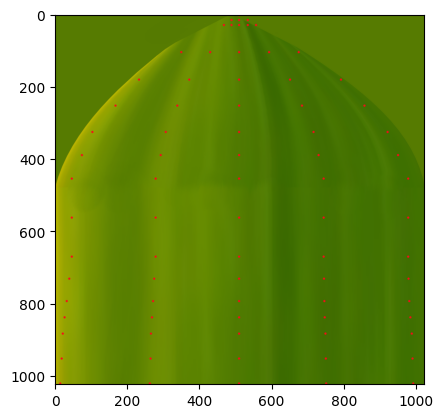

In [7]:
image = cv2.imread('Tex/Grass.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
size = image.shape[0]
for u, v, _ in (texture_vertices * size).astype(np.int32):
    cv2.circle(image, (u, size - v), 3, (250, 10, 25), thickness=-1)
cv2.imwrite('/tmp/ztmp.png', image)
plt.imshow(image)


In [8]:
for i in range(79):
    rc = f'{random.random() * .1} {random.random() * .3 + .7} {random.random() * .2 + .2}'
    print(rc)


0.04969434192561892 0.8664685943327641 0.35261431869697446
0.02314950611350799 0.9667205356382624 0.3904823760043376
0.09102686351019858 0.8259806942797363 0.3191568568827955
0.043838800601411626 0.8311033486847472 0.38543063732341726
0.0002396853122334508 0.97263646175259 0.2630495529868733
0.04847968171640846 0.756819870345993 0.2595471893393427
0.09599382592369105 0.7918740722645004 0.22191739302437338
0.03190462907453289 0.8922930052428766 0.3617019313462102
0.02060528545926287 0.8972837086670674 0.2853655993816463
0.06586736635761964 0.9235447260479562 0.2878421459426621
0.013474632270031352 0.7837975800919088 0.3269572934818413
0.0440056595098881 0.849013214309907 0.2546276264651688
0.0630502311303158 0.9131101422107102 0.3667469847969679
0.08609488077522717 0.9830408235456256 0.3459744473020052
0.0489492924260915 0.7664951940749618 0.3082431768300584
0.09874731761322952 0.9598970448787518 0.2654014991130742
0.05898296633601335 0.801426559308005 0.28801182015992083
0.032676640047